## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Import Data 

In [272]:
# Read the data
Df = yf.download("GLD", start="2019-01-01", end="2022-01-09")

[*********************100%***********************]  1 of 1 completed


In [273]:
# Check the distribution of data
Df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,763.000000,763.000000,763.000000,763.000000,763.000000,7.630000e+02
mean,155.569161,156.223093,154.810669,155.547903,155.547903,9.749001e+06
std,19.455156,19.555775,19.248269,19.409751,19.409751,5.243923e+06
min,119.669998,120.110001,119.540001,119.940002,119.940002,2.250900e+06
25%,140.135002,140.670006,139.365005,140.129997,140.129997,6.449050e+06
50%,162.580002,163.309998,161.649994,162.410004,162.410004,8.353300e+06
75%,169.945000,170.434998,169.130005,169.805000,169.805000,1.165450e+07
max,193.740005,194.449997,192.520004,193.889999,193.889999,4.535500e+07


In [274]:
# Check the type each column
Df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 763 entries, 2018-12-31 to 2022-01-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       763 non-null    float64
 1   High       763 non-null    float64
 2   Low        763 non-null    float64
 3   Close      763 non-null    float64
 4   Adj Close  763 non-null    float64
 5   Volume     763 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.7 KB


In [275]:
# # Check for null values under each column
Df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

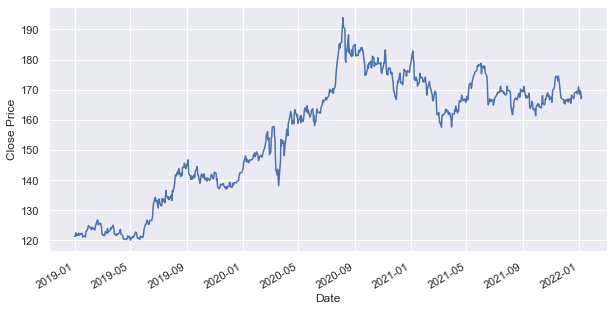

In [276]:
# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 5))
plt.ylabel("Close Price")
plt.show()

## Create input parameters

We will create custom indicators, which will help in making the prediction more accurate.

We will compute the moving average of GLD for 3, 15 and 60 days and store it in S_3, S_15, and S_60, respectively. Then, we will compute the correlation between the closing price and 3 days moving average and store it in Corr. Next, we will compute the difference between High & Open, Open & Low, Open & previous day's Open, and Open & previous day's Close and store it in Std_U, Std_D, OD, and OL, respectively.

In [277]:
# Calculate 3-day moving average of close price
Df['S_3'] = Df['Close'].shift(1).rolling(window=3).mean()

# Calculate 15-day moving average of close price
Df['S_15'] = Df['Close'].shift(1).rolling(window=15).mean()

# Calculate 60-day moving average of close price
Df['S_60'] = Df['Close'].shift(1).rolling(window=60).mean()

# Calculate the correlation between close price and 3 day moving average
Df['Corr'] = Df['Close'].shift(1).rolling(window=10).corr(Df['S_3'].shift(1))


In [278]:
Df.head()

,Open,High,Low,Close,Adj Close,Volume,S_3,S_15,S_60,Corr
Date,,,,,,,,,,
2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400,NaN,NaN,NaN,NaN
2019-01-02,121.349998,121.750000,120.879997,121.330002,121.330002,12776200,NaN,NaN,NaN,NaN
2019-01-03,121.779999,122.459999,121.730003,122.430000,122.430000,15440800,NaN,NaN,NaN,NaN
2019-01-04,121.320000,121.599998,120.690002,121.440002,121.440002,13334000,121.670001,NaN,NaN,NaN
2019-01-07,122.160004,122.220001,121.570000,121.860001,121.860001,7473600,121.733335,NaN,NaN,NaN


In [279]:
Df['Std_U'] = Df['High']-Df['Open']
Df['Std_D'] = Df['Open']-Df['Low']

Df['OD'] = Df['Open']-Df['Open'].shift(1)
Df['OL'] = Df['Open']-Df['Close'].shift(1)

Df.tail()

,Open,High,Low,Close,Adj Close,Volume,S_3,S_15,S_60,Corr,Std_U,Std_D,OD,OL
Date,,,,,,,,,,,,,,
2022-01-03,168.860001,169.009995,168.000000,168.330002,168.330002,9014400,169.783335,168.010667,168.079999,0.630236,0.149994,0.860001,-1.669998,-2.100006
2022-01-04,168.899994,169.720001,168.729996,169.570007,169.570007,6965600,169.696671,168.127334,168.149499,0.428873,0.820007,0.169998,0.039993,0.569992
2022-01-05,170.619995,170.929993,168.899994,169.059998,169.059998,8715600,169.620005,168.298667,168.238499,0.338725,0.309998,1.720001,1.720001,1.049988
2022-01-06,167.160004,167.750000,166.860001,166.990005,166.990005,10902700,168.986669,168.540000,168.324166,0.106713,0.589996,0.300003,-3.459991,-1.899994
2022-01-07,167.369995,168.009995,166.860001,167.750000,167.750000,8191600,168.540003,168.596001,168.362999,-0.060493,0.639999,0.509995,0.209991,0.379990


## Create X and y datasets

A machine learning model's accuracy in making predictions depends on the kind of data provided to it.

We will create an input dataset X and output datasets yU and yD for feeding into the linear regression model we are looking to build.

In [280]:
X = Df[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr']]
X.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr
Date,,,,,,,
2022-01-03,168.860001,169.783335,168.010667,168.079999,-1.669998,-2.100006,0.630236
2022-01-04,168.899994,169.696671,168.127334,168.149499,0.039993,0.569992,0.428873
2022-01-05,170.619995,169.620005,168.298667,168.238499,1.720001,1.049988,0.338725
2022-01-06,167.160004,168.986669,168.540000,168.324166,-3.459991,-1.899994,0.106713
2022-01-07,167.369995,168.540003,168.596001,168.362999,0.209991,0.379990,-0.060493


In [281]:
yU = Df['Std_U']
yU.tail()

Date
2022-01-03    0.149994
2022-01-04    0.820007
2022-01-05    0.309998
2022-01-06    0.589996
2022-01-07    0.639999
Name: Std_U, dtype: float64

In [282]:
yD = Df['Std_D']
yD.tail()

Date
2022-01-03    0.860001
2022-01-04    0.169998
2022-01-05    1.720001
2022-01-06    0.300003
2022-01-07    0.509995
Name: Std_D, dtype: float64

## Pipeline 

In a machine learning model, there are many tasks that must be executed in sequential order. For this reason, we define a list containing tuples that specify the algo tasks given in the order of execution.

Specify in the steps a list of (name, transform) tuples. The 'name' is the variable name given to the task and 'transform' is the function used to perform the task. Then, sequentially apply a list of transforms specified in steps using the pipeline.

Syntax:
    
        steps = [(name_1,transform_1),(name_2,transform_2)....(name_n,transform_n)
        Pipeline(steps) 


## Data Preprocessing

In a machine learning model, it is essential to feed the model with preprocessed data. Raw data contains many errors, and using such data will result in inconsistent and erroneous results.

### Imputer 

We instantiate the imputer function, which helps in identifying and replacing missing values. One might think it would be easy to drop the NaN values and then make the prediction based on the rest of the dataset. This will lead to losing out on the information provided by the non-NaN values in other parameters. To tackle this problem, we will be using the imputer function.

The imputer function takes the first argument as the type of missing value to be replaced. In this case, we have represented NaN in this field, as we are looking to replace the non-numerical values. The following argument to be entered is the strategy to be used for replacing the NaN values. We could either choose the mean, median or most frequent value of the dataset.

### Scaling

Suppose a feature has a variance of an order of magnitude larger than that of the other features. In that case, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. To achieve this, we call the Standard Scaler function.

In [283]:
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('linear',LinearRegression())]     
pipeline = Pipeline(steps)

## Hyperparameters 

There are some parameters that the model itself cannot estimate, but we still need to account for them as they play a crucial role in increasing the performance of the system. Such parameters are called hyperparameters. Hear, including the intercept term in our calculations is something that we have chosen as the hyperparameter. You can add more hyperparameters to tune the algo.

In [284]:
parameters = {'linear__fit_intercept':[0,1]}

### Grid search cross-validation 

Cross-validation indicates the model’s performance in a practical situation. Cross-validation aims to test the model during the training phase to tackle problems like overfitting and give an insight into how the model will generalize to an independent dataset. We will use the GridSearchCV function, which is an inbuilt function for running cross-validation.

We have set cv=5, which implies that the grid search will consider 5 rounds of cross-validation for averaging the performance results.

In [285]:
reg = GridSearchCV(pipeline, parameters, cv=5)

## Split test and train data

Now, we will split data into train and test data set.

    1) First, 80% of data is used for training and the remaining data for testing.
    2)Fit the training data to a grid search function.

In [286]:
t = .8
split = int(t*len(Df))
reg.fit(X[:split],yU[:split])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputation',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

## Prediction using Linear Regression  

We will call the best_params_ function and pass the linear_fit_intercept as an argument to it. This is a boolean parameter that can only take either 0 or 1 as its value, indicating False and True, respectively. Please note that there is a double underscore after the word linear, as it indicates that the parameter after the double underscore belongs to the key before the double underscore.

In [287]:
best_fit = reg.best_params_['linear__fit_intercept']

We will call the LinearRegression function and pass the arguments as fit_intercept = best_fit, where best_fit is the value that decides the intercept parameter for the new instantiation of the LinearRegression function.

In [288]:
reg = LinearRegression(fit_intercept=best_fit)

We will call the imputer function to fill in all the NaN values with the most frequent values.

In [289]:
X = imp.fit_transform(X,yU)

We will fit the linear regression model on the train dataset and predict the upward GLD deviation in the test dataset.

In [290]:
reg.fit(X[:split], yU[:split])
yU_predict = reg.predict(X[split:])

In [291]:
# Assign the predicted values to a new column in the dataframe
Df.reset_index(inplace=True)
Df['Max_U'] = 0
Df.loc[Df.index >= split, 'Max_U'] = yU_predict
Df.loc[Df['Max_U'] < 0, 'Max_U'] = 0

Similarly, we predict the downward GLD deviation in the test dataset.

In [292]:
reg = GridSearchCV(pipeline, parameters, cv=2)
reg.fit(X[:split], yD[:split])
best_fit = reg.best_params_['linear__fit_intercept']
reg = LinearRegression(fit_intercept=best_fit)
X = imp.fit_transform(X, yD)
reg.fit(X[:split], yD[:split])

yD_predict = reg.predict(X[split:])

In [293]:
# Assign the predicted values to a new column in the data frame
Df['Max_D'] = 0
Df.loc[Df.index >= split, 'Max_D'] = yD_predict
Df.loc[Df['Max_D'] < 0, 'Max_D'] = 0

Df.set_index('Date', inplace=True)

We will use the predicted upside deviation values to calculate the high price and the predicted downside deviation values to calculate the low price

In [294]:
# We will use the predicted upside deviation values to calculate the high price
Df['P_H'] = Df['Open']+Df['Max_U']
Df['P_L'] = Df['Open']-Df['Max_D']

Df[['High', 'P_H', 'Low', 'P_L']].tail()

,High,P_H,Low,P_L
Date,,,,
2022-01-03,169.009995,169.595996,168.000000,167.723059
2022-01-04,169.720001,169.745093,168.729996,168.007127
2022-01-05,170.929993,171.384629,168.899994,169.785272
2022-01-06,167.750000,167.871664,166.860001,166.018618
2022-01-07,168.009995,168.170221,166.860001,166.530813


## Strategy returns 

We will use the predicted high and predicted low values to determine whether to buy or sell GLD ETF the next day.

We will sell GLD ETF when

    1) The actual high value is greater than the predicted high value and
    2) The actual low value is greater than the predicted low value

We will buy GLD ETF when

    1) The actual high value is less than the predicted high value and
    2) The actual low value is less than the predicted low value
    
Next, we will compute the GLD returns and strategy returns.

In [295]:
# Trading signal
Df['Signal'] = 0
Df.loc[(Df['High']>Df['P_H']) &(Df['Low']>Df['P_L']),'Signal'] = 1
Df.loc[(Df['High']<Df['P_H']) &(Df['Low']<Df['P_L']),'Signal'] = -1

# Compute GLD returns 
Df['Ret'] = (Df['Close']-Df['Close'].shift(1))/Df['Close'].shift(1)

# Compute strategy returns(
Df['Ret1'] = Df['Ret']*(Df['Signal'].shift(1))

## Plot the Gold returns and strategy returns

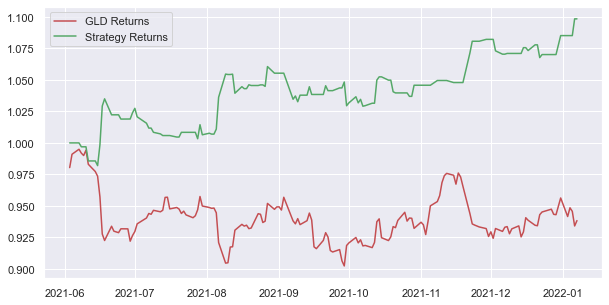

In [296]:
plt.figure(figsize=(10,5))
plt.plot(((Df['Ret'][split:]+1).cumprod()),color='r',label='GLD Returns')
plt.plot(((Df['Ret1'][split:]+1).cumprod()),color='g',label='Strategy Returns')
plt.legend()
plt.show()

## Analyze the performance 

In [297]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

# Calculate the excess daily return by assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = Df['Ret1'][split:] - 0.05/252

# Calculate the annualized Sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe 1.1100727317876473
